# Figure Generation for Manuscript

This notebook generates **Supplementary Figure S7** using **RISK**.  
Figure is based on the high-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014).

---

## Supplementary Figure S7: RISK Analysis of Citation Network
- Citation network of 20,147 nodes and 331,044 edges
- ForceAtlas2 layout used for visualization
- RISK clusters detected with the Leiden algorithm
- Clusters correspond to major research subfields (e.g., quantum mechanics, particle physics, cosmology)
- Annotation check shows clusters reflect thematic structure rather than journal of origin

---

### Workflow
- **Input:** High-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014)  
- **Tools:** Python, RISK, NetworkX, ForceAtlas2, Matplotlib  
- **Output:** High-resolution figure for **Supplementary Figure S7**

In [4]:
# First, extract snippets from article abstracts and determine their subfield(s)

import gzip
import requests
import tarfile
import io
import re
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import defaultdict


# Enhanced function to extract the journal reference from the abstract content
def extract_journal_ref(text, citation):
    """
    Extract journal references from text and map them to the given citation.
    """
    journals = defaultdict(list)
    # Updated pattern to capture journal names, including multi-word names with spaces and periods
    journal_pattern = r"Journal-ref:\s*([A-Za-z0-9\.\s\-]+)"

    # Search for the Journal-ref field
    journal_match = re.search(journal_pattern, text)
    if journal_match:
        # Extract the full journal reference string
        journal_ref = journal_match.group(1).strip()

        # Extract only words ending with a period, conjoining them into a single key
        words_with_periods = re.findall(r"[A-Za-z]+\.", journal_ref)
        # Don't add single period abbr
        if words_with_periods and len(words_with_periods) > 1:
            # Join the words, remove spaces, and create a compact key
            journal_name = "".join(words_with_periods).strip()
            journals[journal_name].append(citation)

    return journals


# The dictionary of subfields with their respective keywords
subfield_keywords = {
    "String Theory": ["string", "brane", "superstring", "m-theory", "tachyon", "compact", "calabi"],
    "General Relativity": [
        "gravit",
        "spacetime",
        "horizon",
        "einstein",
        "schwarzschild",
        "geodesic",
    ],
    "Cosmology": [
        "cosmo",
        "inflation",
        "dark matter",
        "dark energy",
        "big bang",
        "multiverse",
        "redshift",
    ],
    "Quantum Mechanics": [
        "quant",
        "wavefunc",
        "superposit",
        "entangle",
        "decoher",
        "tunnel",
        "uncert",
    ],
    "Quantum Field Theory": [
        "gaug",
        "lagrang",
        "renormal",
        "symmetry",
        "feynman",
        "fermion",
        "boson",
    ],
    "Condensed Matter Physics": [
        "supercond",
        "bandgap",
        "quasipart",
        "phonon",
        "topolog",
        "fermi",
        "insulat",
    ],
    "Particle Physics": ["quark", "lepton", "gluon", "colli", "neutrino", "higgs", "hadron"],
    "Nuclear Physics": ["fus", "fission", "nucleon", "deuteron", "isotope", "heavy ion", "neutron"],
}


# Check if any of the subfield-specific keywords appear in the text
def find_subfield_matches_in_text(subfield_keywords, text, citation):
    matches = defaultdict(list)
    for subfield, keywords in subfield_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                matches[subfield].append(citation)
                break
    return matches


# Process an abstract based on mode (either 'subfield_citations' or 'journal')
def process_abstract(file_content, citation, mode="subfield_citations"):
    if mode == "subfield_citations":
        return find_subfield_matches_in_text(subfield_keywords, file_content, citation)
    elif mode == "journal":
        return extract_journal_ref(file_content, citation)


# Stream and process the tar.gz file for abstracts based on mode
def stream_and_process_tar_gz(url, mode="subfield_citations"):
    response = requests.get(url, stream=True)
    result_map = defaultdict(list)

    if response.status_code == 200:
        file_like_object = io.BytesIO(response.raw.read())
        with tarfile.open(fileobj=file_like_object, mode="r:gz") as tar:
            for member in tar.getmembers():
                if member.isfile() and member.name.endswith(".abs"):
                    citation = member.name.split("/")[-1].replace(".abs", "")
                    file_content = tar.extractfile(member).read().decode("utf-8")

                    # Process abstract based on the specified mode
                    processed_data = process_abstract(file_content, citation, mode)

                    # Update result_map with processed data
                    for key, citations in processed_data.items():
                        result_map[key].extend(citations)

    return result_map


# URL for the abstracts (cit-HepTh)
abstracts_url = "https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz"

# Process the abstracts and aggregate citations by subfield
subfield_citations_map = stream_and_process_tar_gz(abstracts_url)

# Test the updated function with mode 'journal'
journal_citations_map = stream_and_process_tar_gz(abstracts_url, mode="journal")

# # Output the mapping of subfields to citations
# for subfield, citations in subfield_citations_map.items():
#     print(f"{subfield}: {citations}")

In [2]:
# Build citation network from citation file


def stream_and_build_network(url):
    """
    Stream a gzipped edge list from a URL and build a NetworkX graph.
    """
    G = nx.Graph()
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        gzip_file = io.BytesIO(response.content)
        with gzip.GzipFile(fileobj=gzip_file) as f:
            for line in f:
                decoded_line = line.decode("utf-8")
                if not decoded_line.startswith("#"):
                    parts = decoded_line.strip().split()
                    if len(parts) == 2:
                        from_node, to_node = parts
                        G.add_edge(from_node, to_node)
    return G


citation_url = "https://snap.stanford.edu/data/cit-HepTh.txt.gz"
print("Building graph...")
# Build the citation graph
citation_graph = stream_and_build_network(citation_url)

Building graph...


In [3]:
# Function to remove nodes with fewer than N edges
def remove_low_degree_nodes(G, min_edges=1):
    """
    Remove nodes from the graph that have fewer than min_edges edges.
    """
    nodes_to_remove = [node for node, degree in G.degree() if degree < min_edges]
    G.remove_nodes_from(nodes_to_remove)
    return G


# Function to sample N nodes from the graph and return a subgraph
def sample_graph(G, num_nodes):
    """
    Sample a subgraph with a specified number of nodes.
    """
    sampled_nodes = random.sample(list(G.nodes()), min(num_nodes, G.number_of_nodes()))
    G_sampled = G.subgraph(sampled_nodes)
    return G_sampled

Num nodes before pruning for min edge count: 27770
Num nodes after pruning for min edge count: 20157


100%|██████████████████████████████████████████████████████████████████| 250/250 [02:52<00:00,  1.45it/s]


BarnesHut Approximation  took  50.05  seconds
Repulsion forces  took  108.98  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  8.77  seconds
AdjustSpeedAndApplyForces step  took  2.38  seconds


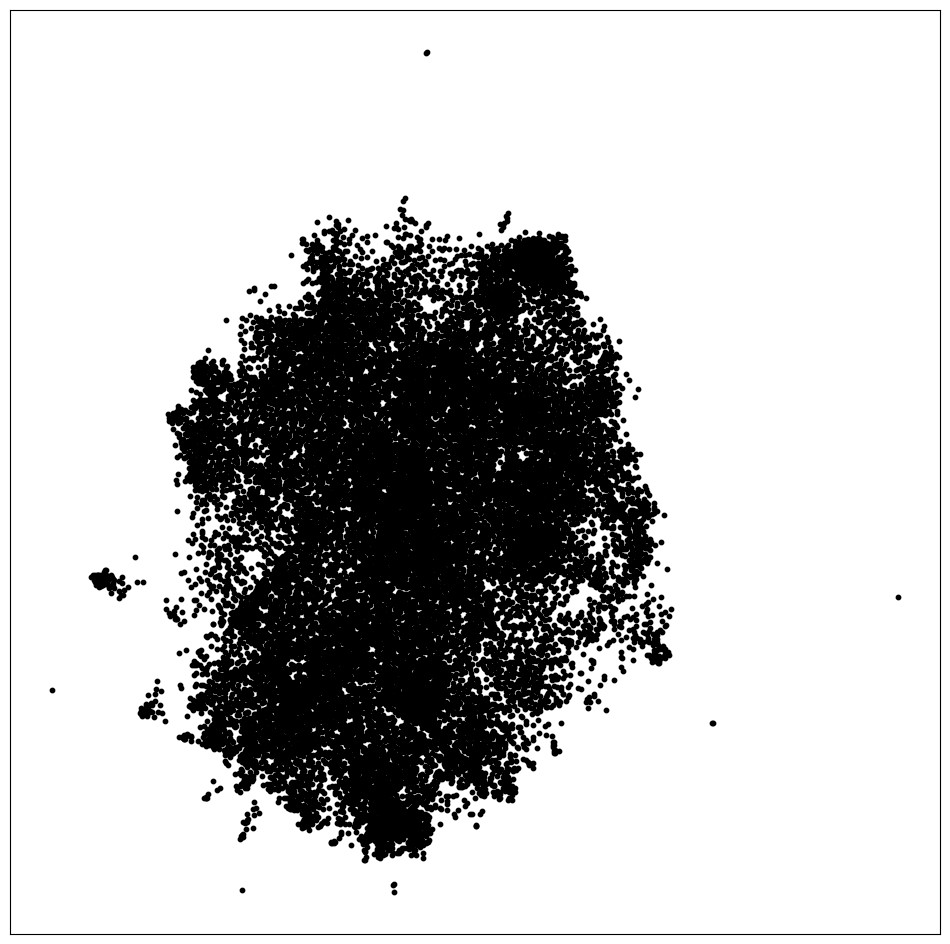

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import numpy as np
import random

random.seed(8)
np.random.seed(8)


def apply_forceatlas2_layout(
    G,
    iterations: int = 200,
    outbound_attraction_distribution: bool = False,
    lin_log_mode: bool = False,
    adjust_sizes: bool = False,
    edge_weight_influence: float = 1.0,
    jitter_tolerance: float = 1.0,
    barnes_hut_optimize: bool = True,
    barnes_hut_theta: float = 1.2,
    scaling_ratio: float = 2.0,
    strong_gravity_mode: bool = False,
    gravity: float = 1.0,
    verbose: bool = True,
):
    """
    Apply the ForceAtlas2 layout to a NetworkX graph G and update each node's 'pos' attribute with 'x' and 'y'.
    """
    # Initialize ForceAtlas2 layout algorithm
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=outbound_attraction_distribution,
        # linLogMode=lin_log_mode,
        adjustSizes=adjust_sizes,
        edgeWeightInfluence=edge_weight_influence,
        jitterTolerance=jitter_tolerance,
        barnesHutOptimize=barnes_hut_optimize,
        barnesHutTheta=barnes_hut_theta,
        scalingRatio=scaling_ratio,
        strongGravityMode=strong_gravity_mode,
        gravity=gravity,
        verbose=verbose,
    )

    # Extract node positions as a list of dictionaries
    pos = forceatlas2.forceatlas2_networkx_layout(
        G, pos=None, iterations=iterations, weight_attr="weight"
    )

    return pos


# Remove nodes with less than N edges
print(f"Num nodes before pruning for min edge count: {len(citation_graph.nodes())}")
G = remove_low_degree_nodes(citation_graph.copy(), min_edges=7)
print(f"Num nodes after pruning for min edge count: {len(G.nodes())}")

# # Sample 10,050 nodes from the large graph
# G_sampled = sample_graph(G, 10_150)
# Or just copy the whole graph
G_sampled = G.copy()

# Iteration count
iterations = 250

# Generate ForceAtlas2 layout for the sampled graph
pos = apply_forceatlas2_layout(
    G_sampled,
    iterations=iterations,
    outbound_attraction_distribution=False,
    adjust_sizes=False,
    edge_weight_influence=0.005,
    jitter_tolerance=1.0,
    barnes_hut_optimize=True,
    barnes_hut_theta=1.25,
    scaling_ratio=1.0,
    strong_gravity_mode=True,
    gravity=0.05,
    verbose=True,
)

# Draw the sampled graph without edges
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_sampled, pos, node_size=10, node_color="black")
plt.show()

In [5]:
# Add the positions to the nodes in the sampled graph


def add_positions_to_nodes(G, pos):
    """
    Add position information as node attributes.
    """
    for node, position in pos.items():
        G.nodes[node]["pos"] = position


add_positions_to_nodes(G_sampled, pos)

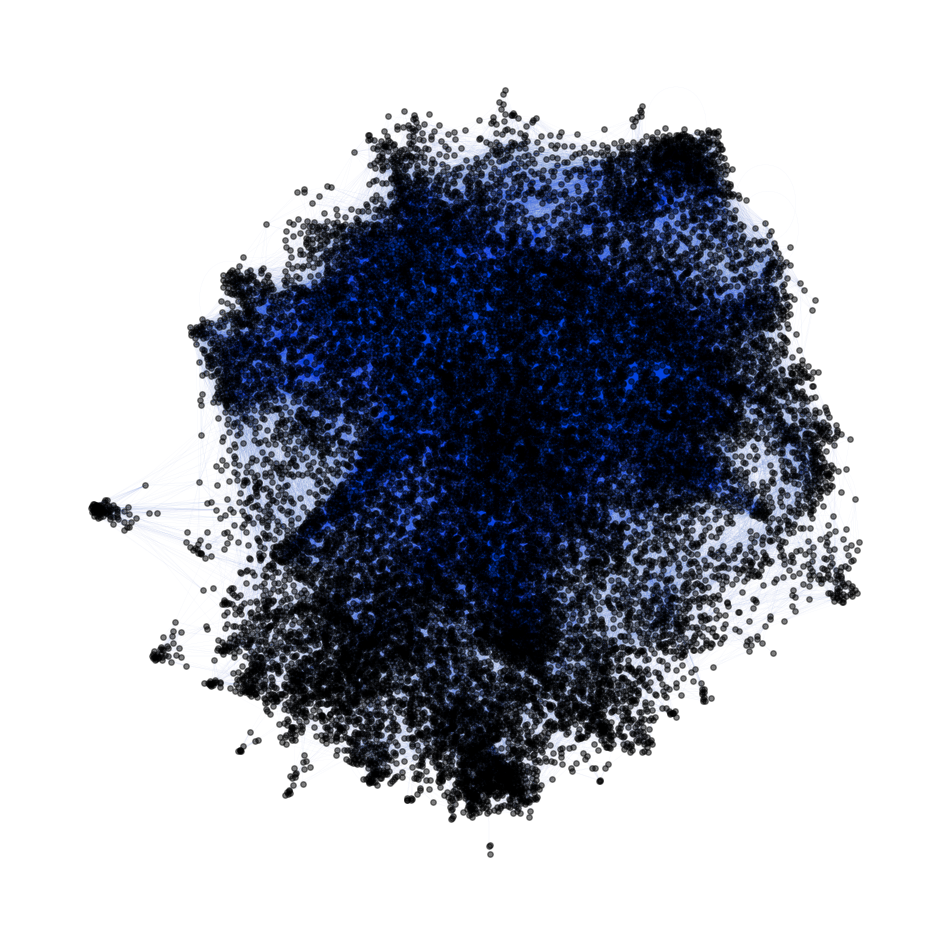

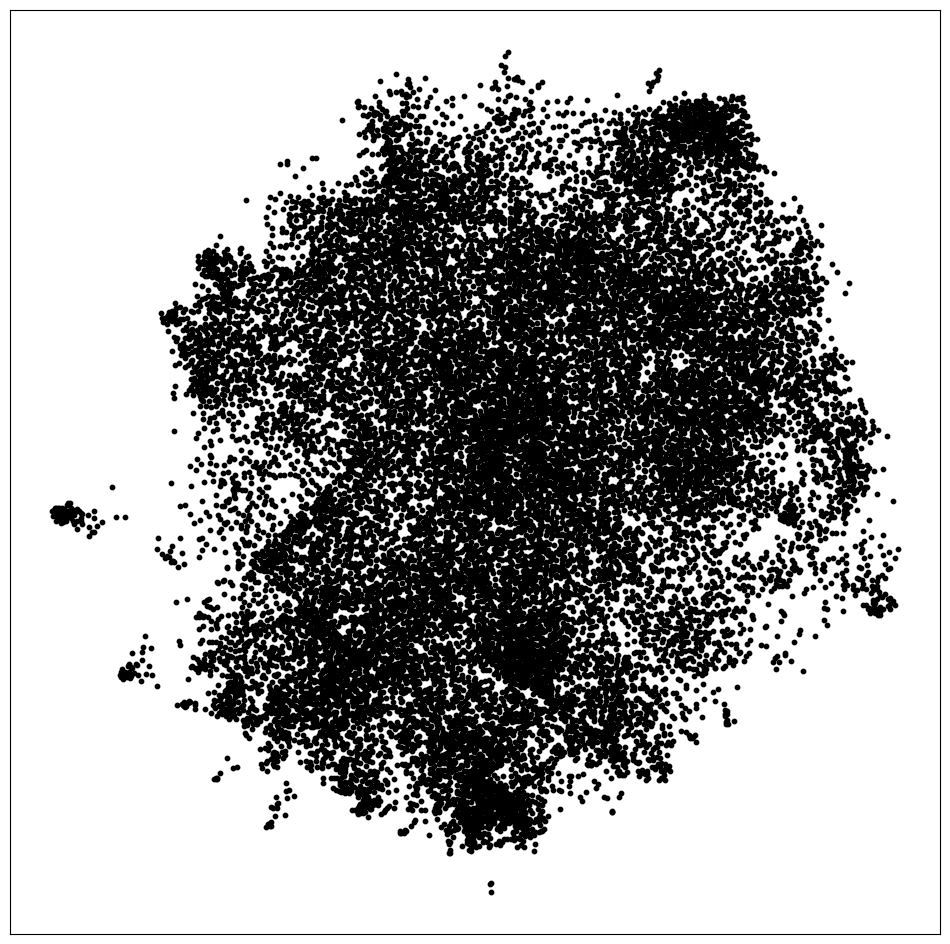

In [6]:
def remove_farthest_from_centroid(G, positions, N=10):
    """
    Remove the N farthest nodes from the centroid, update positions, and plot the remaining graph.
    """
    # Calculate the centroid of the graph (average position of all nodes)
    centroid = np.mean(list(positions.values()), axis=0)

    # Calculate the Euclidean distance of each node from the centroid
    distances_from_centroid = {
        node: np.linalg.norm(np.array(pos) - centroid) for node, pos in positions.items()
    }

    # Sort nodes by distance from the centroid and take the N farthest nodes
    farthest_nodes = sorted(distances_from_centroid, key=distances_from_centroid.get, reverse=True)[
        :N
    ]

    # Remove the farthest nodes from the graph
    G_removed = G.copy()
    G_removed.remove_nodes_from(farthest_nodes)

    # Remove positions of the farthest nodes, but only for nodes still in the graph
    positions_removed = {node: pos for node, pos in positions.items() if node in G_removed.nodes()}

    # Add 'x' and 'y' attributes for the remaining nodes
    for node, pos in positions_removed.items():
        G_removed.nodes[node]["x"] = pos[0]
        G_removed.nodes[node]["y"] = pos[1]

    # Add edge weights if they exist in the original graph
    for u, v, data in G_removed.edges(data=True):
        if "weight" in G[u][v]:
            G_removed[u][v]["weight"] = G[u][v]["weight"]

    # Plot the remaining graph with updated positions
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G_removed, positions_removed, node_size=15, node_color="xkcd:black", alpha=0.5
    )
    nx.draw_networkx_edges(G_removed, positions_removed, width=0.01, edge_color="xkcd:blue")
    plt.axis("off")
    plt.show()

    return G_removed, positions_removed


# Remove the 10 nodes farthest from the centroid and update the graph
G_updated, pos_updated = remove_farthest_from_centroid(G_sampled, pos, N=10)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_updated, pos_updated, node_size=10, node_color="black")
plt.show()

In [25]:
# Save the graph to a gpickle file
import pickle


def save_graph_as_gpickle(graph, file_path):
    """
    Saves a NetworkX graph as a gpickle file using pickle.
    """
    with open(file_path, "wb") as f:
        pickle.dump(graph, f)


# save_graph_as_gpickle(G_updated, './data/gpickle/20250117_high_energy_physics_citations.gpickle')

## Apply RISK to Network

### NOTE: Begin analysis here if you already have a satisfactory Gpickle file of the citation network above.

### Supplementary Figure S7.B: Annotate using Physics Subfields

- This example attempts to capture true relationships


In [1]:
import risk

print(risk.__version__)

0.0.14


In [6]:
# Initialize the RISK object

from risk import RISK

risk = RISK(verbose=True)

In [11]:
#  Sphere with 0 depth is the best for the citation network
network = risk.load_network_gpickle(
    "./data/gpickle/20250117_high_energy_physics_citations.gpickle",
    compute_sphere=True,
    surface_depth=0.0,
    min_edges_per_node=0,
)

# Load annotation
annotation = risk.load_annotation_dict(
    network=network,
    content=subfield_citations_map,
)

---------------
Loading network
---------------
Filetype: GPickle
Filepath: ./data/gpickle/20250117_high_energy_physics_citations.gpickle
Minimum edges per node: 0
Projection: Sphere
Surface depth: 0.0
20147 out of 20147 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.
Initial node count: 20147
Final node count: 20147
Initial edge count: 331044
Final edge count: 331009
------------------
Loading annotation
------------------
Filetype: Dictionary
Filepath: In-memory dictionary
Minimum number of nodes per annotation term: 1
Maximum number of nodes per annotation term: 10000
Number of input annotation terms: 8
Number of remaining annotation terms: 8


In [15]:
import time

start_time = time.time()

# Perform annotation overrepresentation analysis by computing p-values for network neighborhoods using the permutation test
neighborhoods = risk.load_neighborhoods_permutation(
    network=network,
    annotation=annotation,
    distance_metric="leiden",
    leiden_resolution=2.0,
    fraction_shortest_edges=0.25,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=6,  # Leverage multiple cores to speed up process
)

end_time = time.time()
elapsed = end_time - start_time
print(f"Neighborhood definition and permutation test completed in {elapsed:.2f} seconds.")

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 6
Null distribution: 'network'
Distance metric: 'leiden (resolution=2.0)'
Edge length threshold: 0.25
Random seed: 887


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.46it/s]

Neighborhood definition and permutation test completed in 37.51 seconds.


In [13]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotation=annotation,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.001,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.1,
    linkage_criterion="off",
    linkage_method="auto",
    linkage_metric="auto",
    linkage_threshold="auto",
    min_cluster_size=10,
    max_cluster_size=100_000,
)

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.001
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.1
-----------------------
Finding top annotations
-----------------------
Min cluster size: 10
Max cluster size: 100000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------
Clustering is turned off. Skipping clustering.


---------------
Loading plotter
---------------


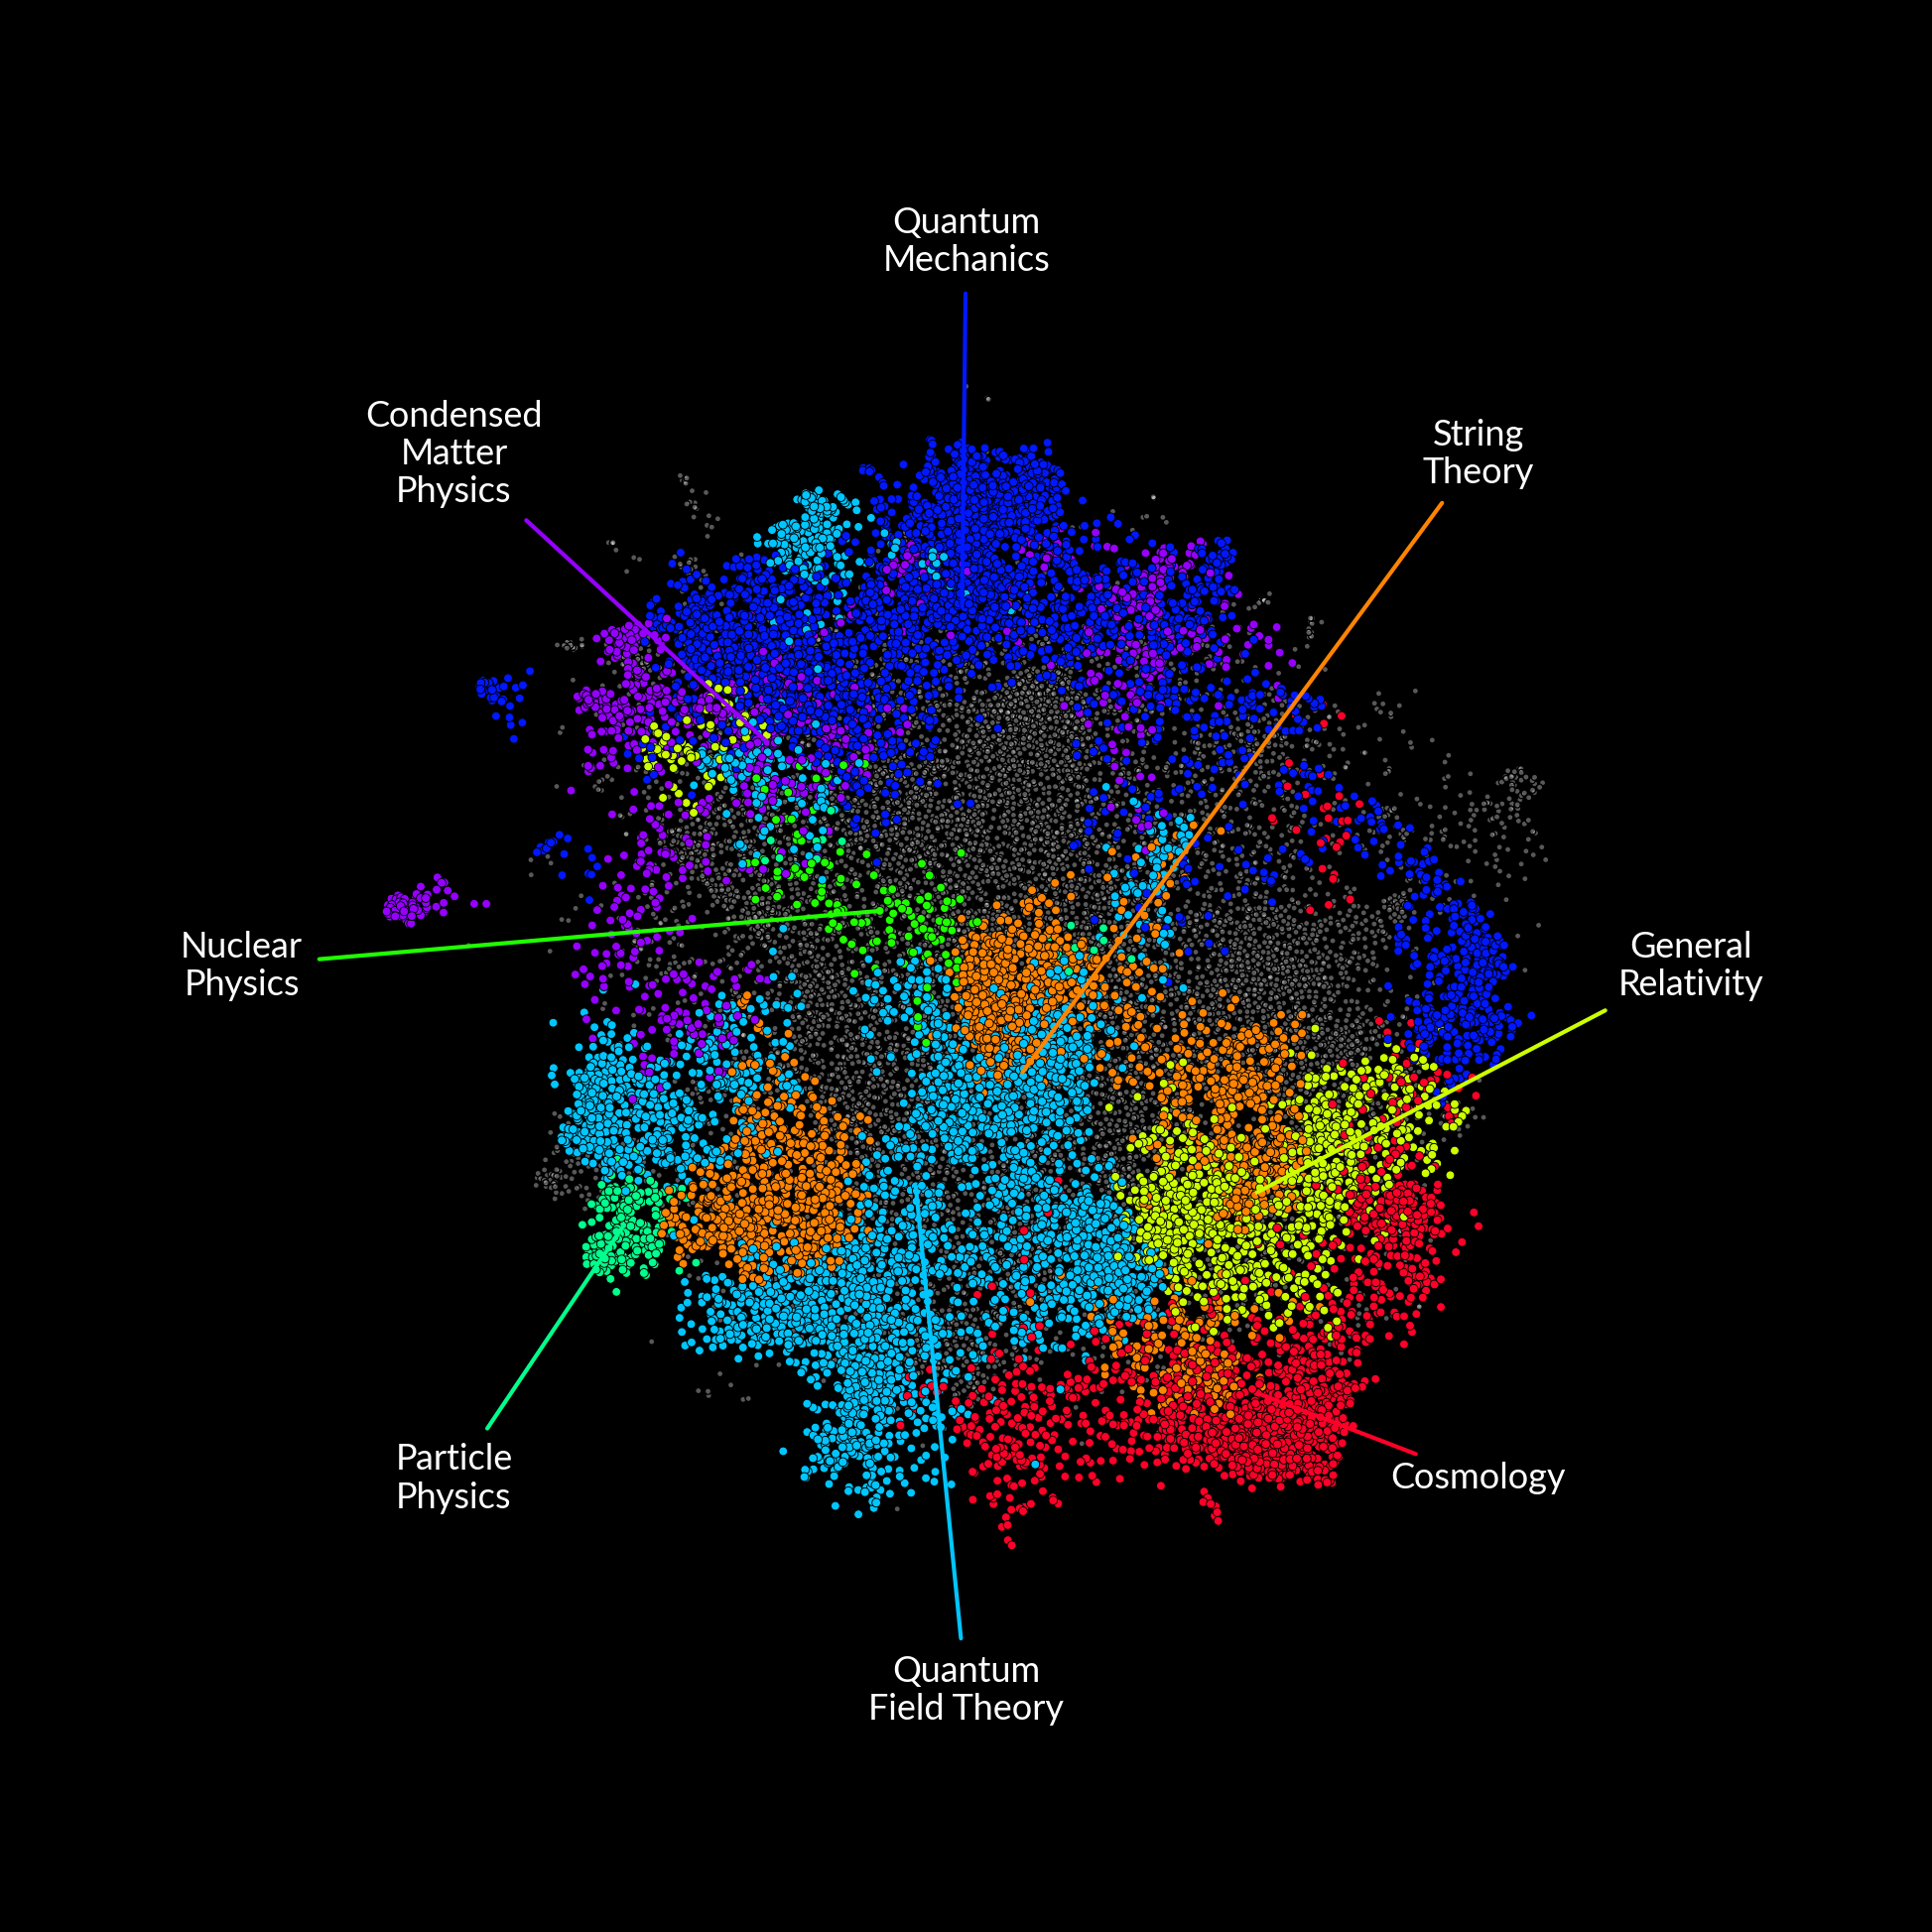

In [14]:
# Plot citations network with subfield annotations

random_seed = 866

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(20, 20),
    background_color="black",
)

# Plot a subnetwork with custom node and edge attributes
plotter.plot_subnetwork(
    nodes=graph.node_id_to_node_label_map.values(),
    node_size=20,
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.00,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=0.35,
    edge_alpha=1.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=40,
        nonsignificant_size=0,
    ),
    node_edgewidth=0.65,
    node_shape="o",
    edge_width=0.0,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        # color="black",
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        alpha=1.0,
        blend_colors=False,
        nonsignificant_color="white",
        nonsignificant_alpha=0.5,
        random_seed=random_seed,
    ),
    # node_color="grey",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.05,
    offset=0.10,
    font="Lato",
    fontsize=26,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=3,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=55,
    min_label_lines=1,
    max_label_lines=5,
    min_chars_per_line=1,
    max_chars_per_line=12,
    words_to_omit=None,
    overlay_ids=False,
    ids_to_keep=None,
)

# Finally, save and display the plot
# plotter.savefig("./png/publication/supp_fig_9b.png", dpi=350)

# Display the plot
plotter.show()

## Supplementary Figure S7.A

Empty high-energy physics citation network

---------------
Loading plotter
---------------


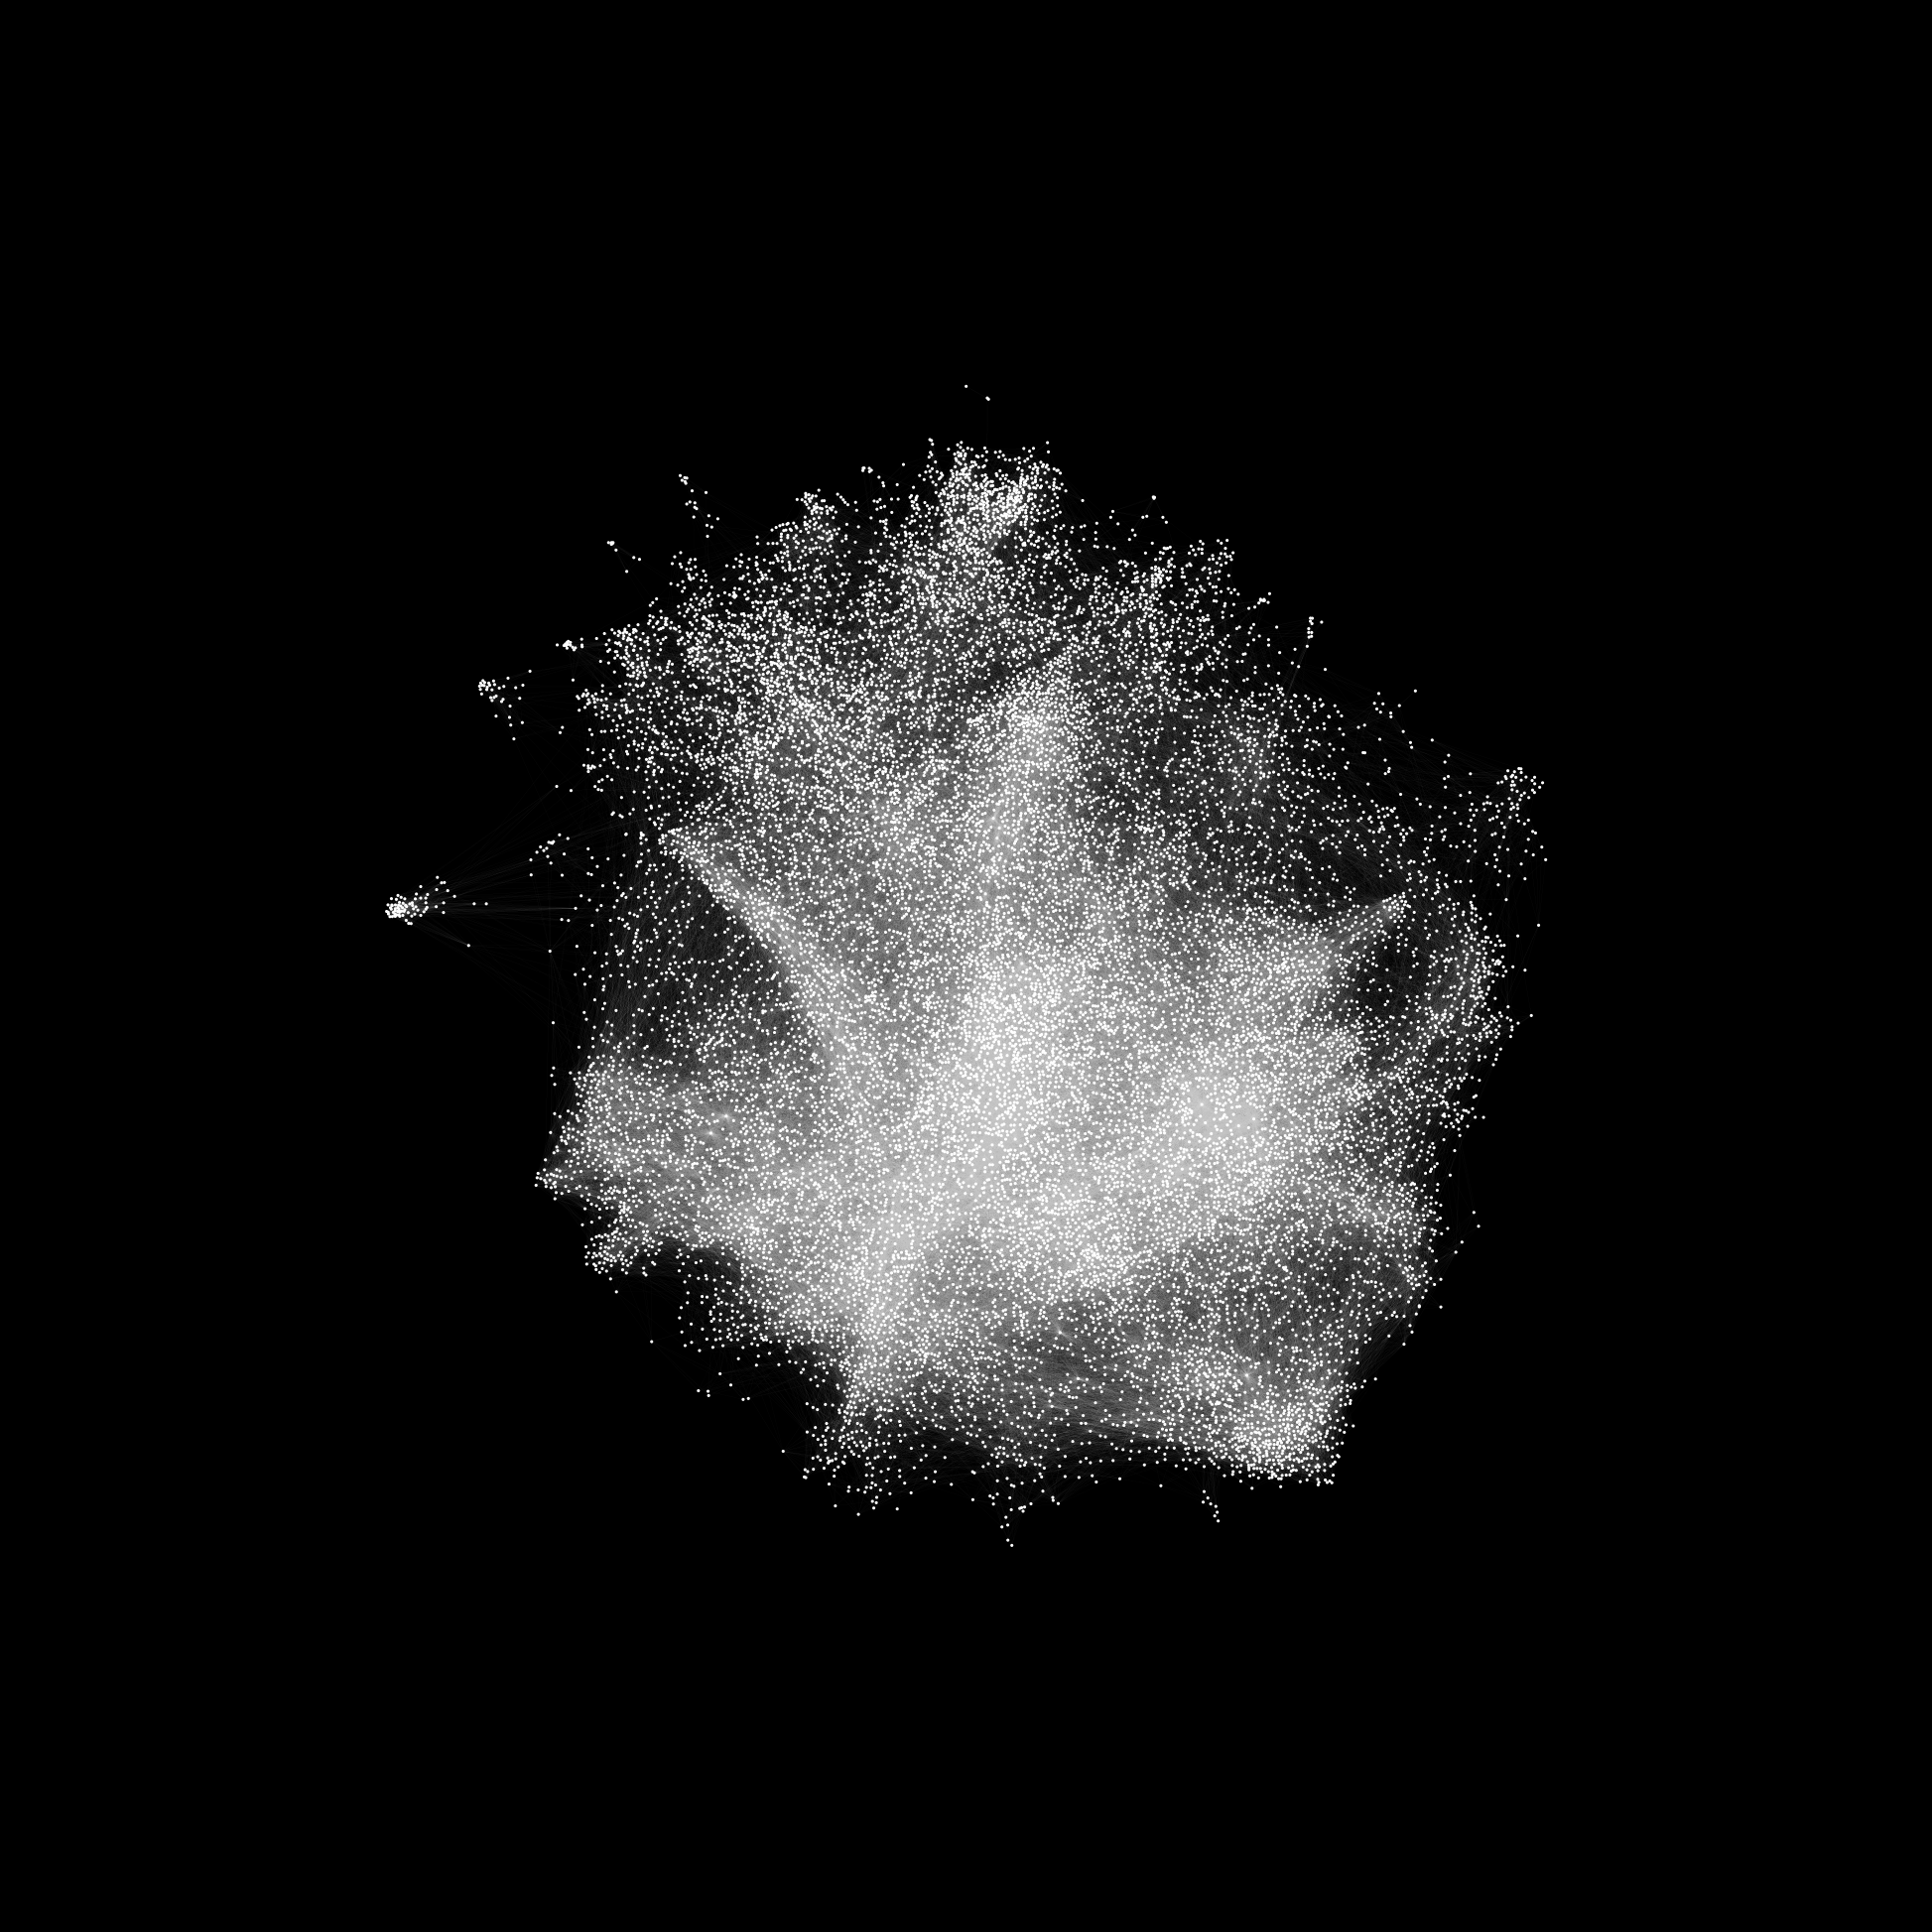

In [16]:
# Initialize the NetworkPlotter with the NetworkGraph object

random_seed = 866

plotter = risk.load_plotter(
    graph=graph,
    figsize=(20, 20),
    background_color="black",
)

# Optional: Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(significant_size=5, nonsignificant_size=5),
    edge_width=0.01,
    node_edgewidth=0.0,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_shape="o",
)

# Finally, save and display the plot
# plotter.savefig("./png/publication/supp_fig_9a.png", dpi=350)

plotter.show()

### Supplementary Figure S7.C: Annotate using Physics Subfields

- This example attempts to capture true relationships


In [17]:
import risk

print(risk.__version__)

0.0.14-beta.2


In [18]:
# Initialize the RISK object

from risk import RISK

risk = RISK(verbose=False)

In [19]:
#  Sphere with 0 depth is the best for the citation network

network_journal = risk.load_network_gpickle(
    "./data/gpickle/20250117_high_energy_physics_citations.gpickle",
    compute_sphere=True,
    surface_depth=0.0,
    min_edges_per_node=0,
)

# Load annotation
annotation_journal = risk.load_annotation_dict(
    network=network_journal,
    content=journal_citations_map,
)

20147 out of 20147 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


In [20]:
# Perform annotation overrepresentation analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods_journal = risk.load_neighborhoods_permutation(
    network=network_journal,
    annotation=annotation_journal,
    distance_metric="leiden",
    leiden_resolution=2.0,
    fraction_shortest_edges=0.25,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=6,  # Leverage multiple cores to speed up process - adjust accordingly to your machine's specs
)

Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.68it/s]


In [21]:
# Get the NetworkGraph object for plotting

graph_journal = risk.load_graph(
    network=network_journal,
    annotation=annotation_journal,
    neighborhoods=neighborhoods_journal,
    tail="right",
    pval_cutoff=0.001,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.1,
    linkage_criterion="distance",
    linkage_method="complete",
    linkage_metric="hamming",
    linkage_threshold=0.251,
    min_cluster_size=10,
    max_cluster_size=100_000,
)

Evaluating linkage methods and metrics: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00]


Linkage criterion: 'distance'
Linkage method: 'complete'
Linkage metric: 'hamming'
Linkage threshold: 0.251


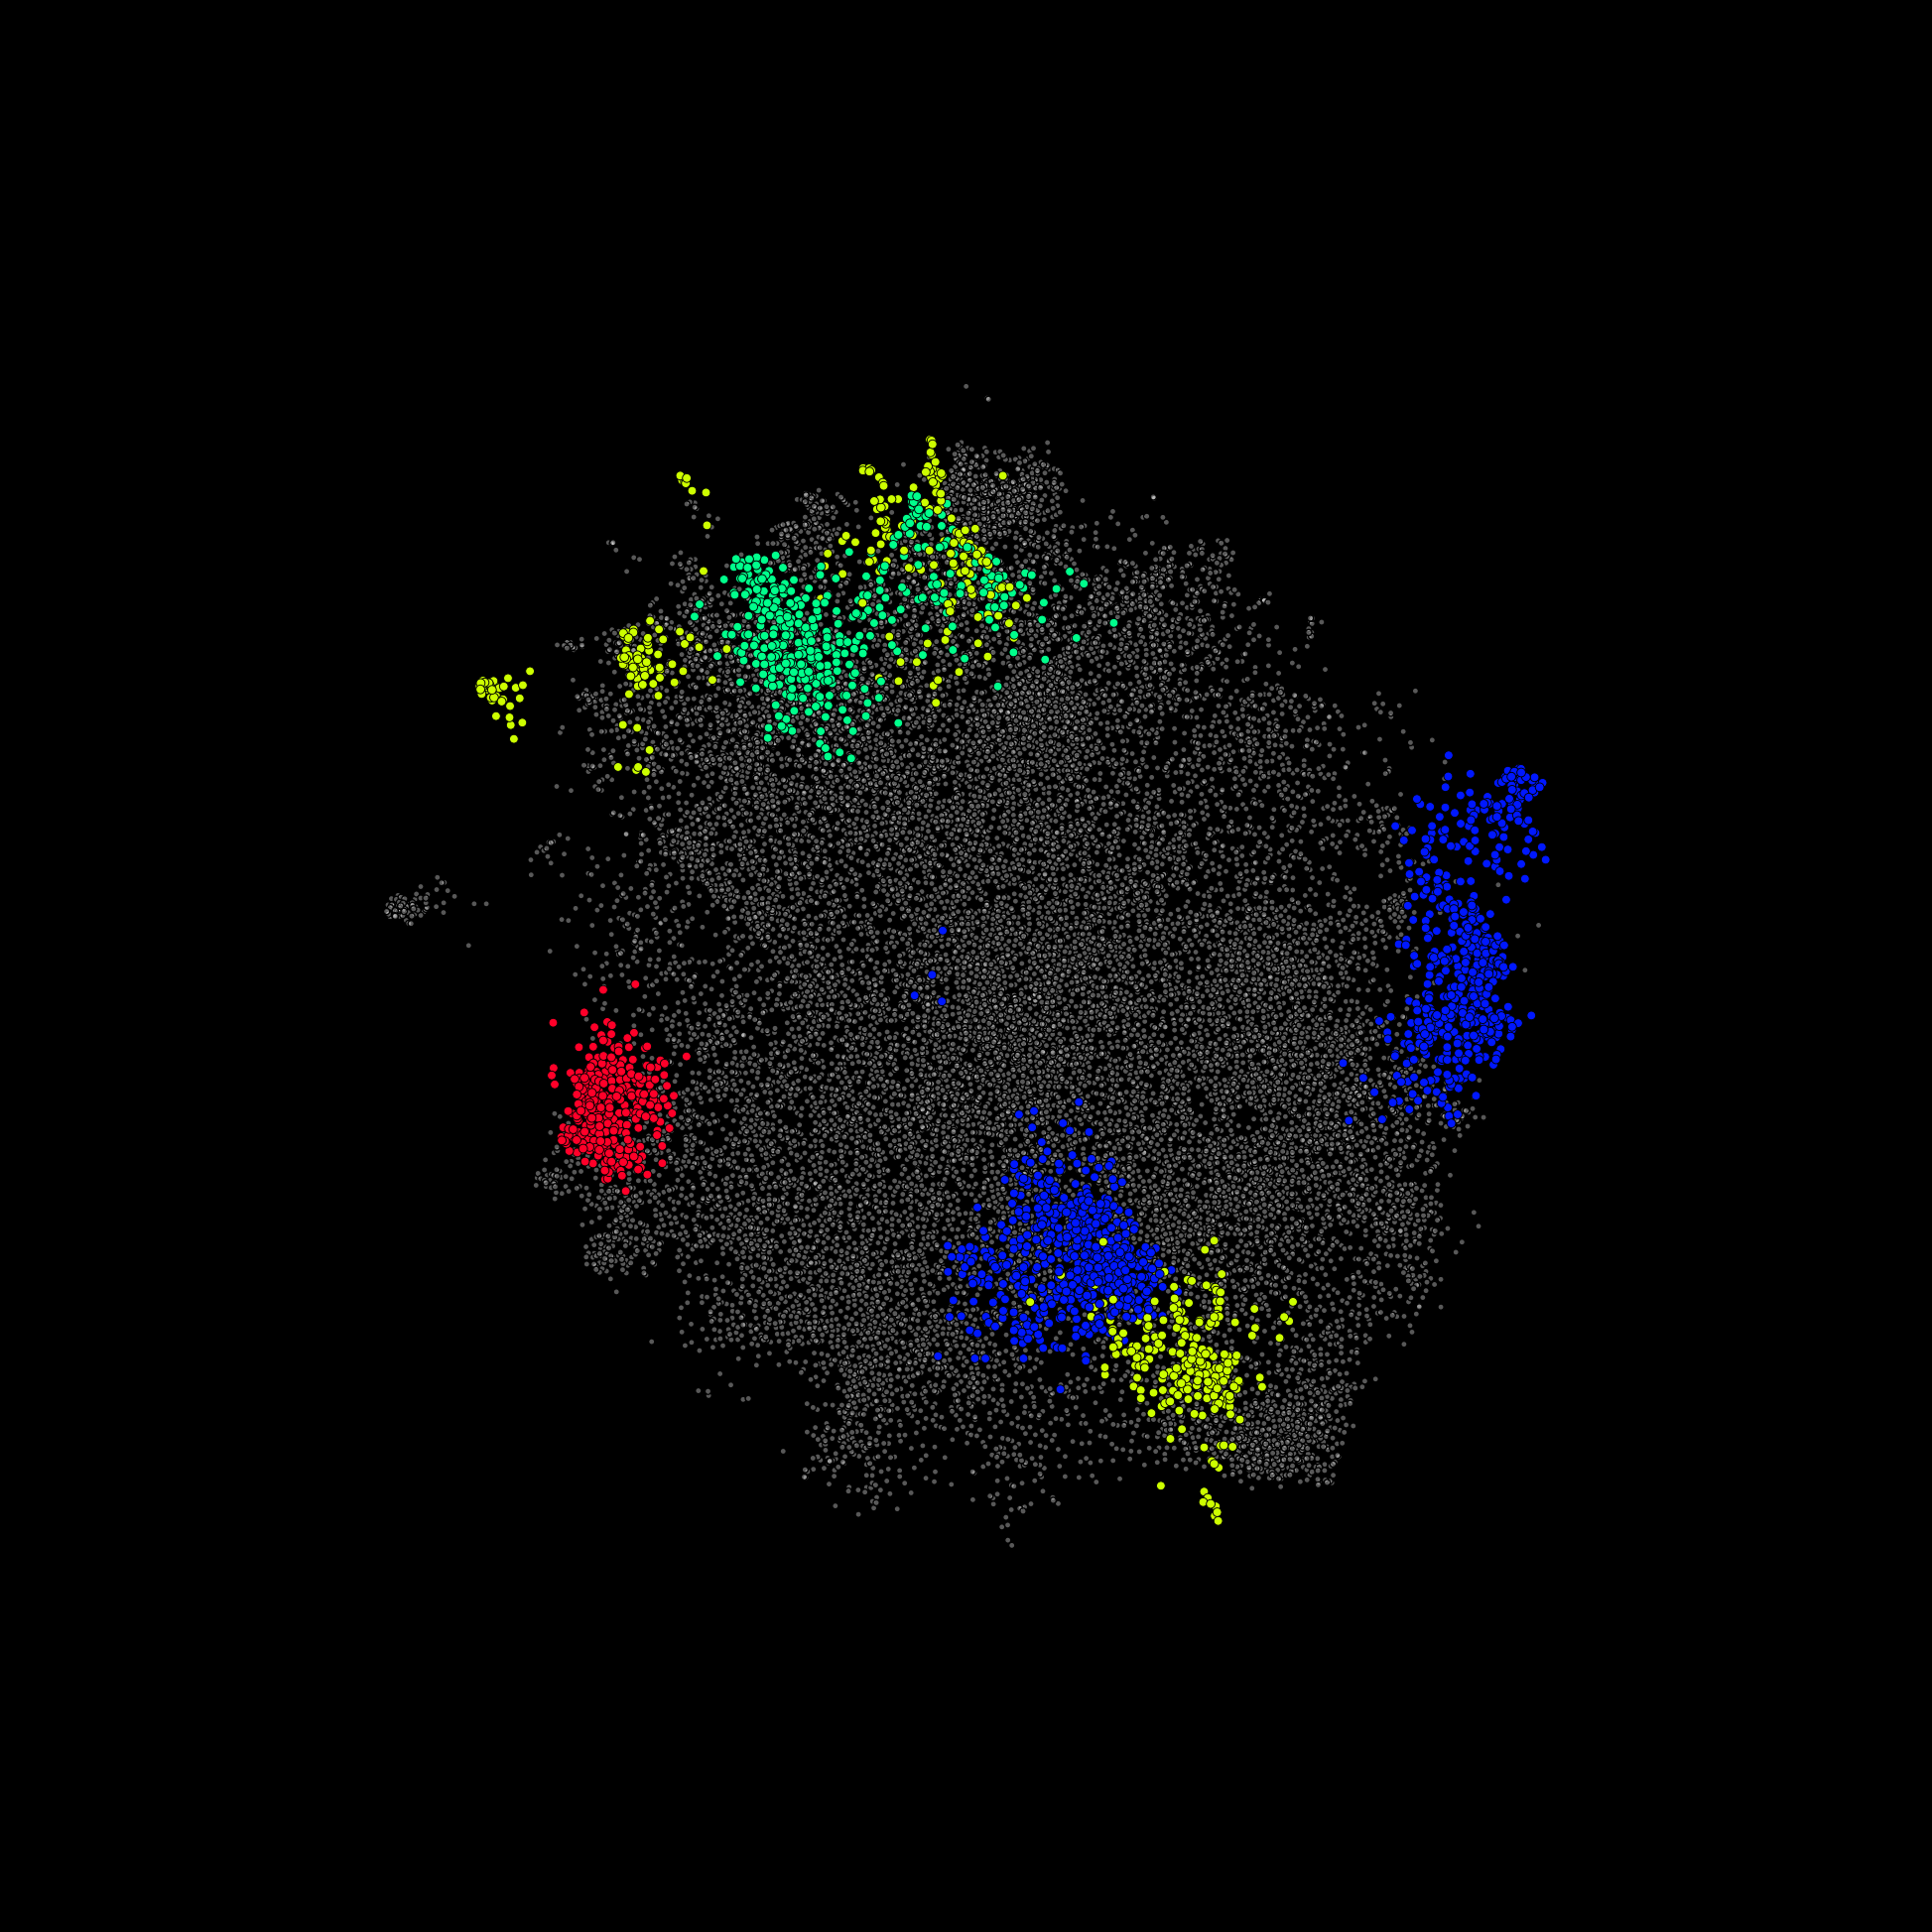

In [22]:
# Plot citations network with subfield annotations

random_seed = 866

# Initialize the NetworkPlotter with the NetworkGraph object
plotter_journal = risk.load_plotter(
    graph=graph_journal,
    figsize=(20, 20),
    background_color="black",
)

# Plot a subnetwork with custom node and edge attributes
plotter_journal.plot_subnetwork(
    nodes=graph.node_id_to_node_label_map.values(),
    node_size=20,
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.00,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=0.35,
    edge_alpha=1.0,
)

# Plot network nodes and edges
plotter_journal.plot_network(
    node_size=plotter_journal.get_annotated_node_sizes(
        significant_size=40,
        nonsignificant_size=0,
    ),
    node_edgewidth=0.65,
    node_shape="o",
    edge_width=0.0,
    node_color=plotter_journal.get_annotated_node_colors(
        cmap="gist_rainbow",
        # color="black",
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        alpha=1.0,
        blend_colors=False,
        nonsignificant_color="white",
        nonsignificant_alpha=0.5,
        random_seed=random_seed,
    ),
    # node_color="grey",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot labels on the network
plotter_journal.plot_labels(
    scale=1.05,
    offset=0.10,
    font="Lato",
    fontsize=26,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=3,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=55,
    min_label_lines=0,
    max_label_lines=0,
    min_chars_per_line=1,
    max_chars_per_line=12,
    words_to_omit=None,
    overlay_ids=False,
    ids_to_keep=None,
)


# Finally, save and display the plot
# plotter_journal.savefig("./png/publication/supp_fig_9c.png", dpi=350)

# Display the plot
plotter_journal.show()

In [24]:
# Print out all domain attribute terms

graph_journal.domain_id_to_domain_terms_map

{1: 'ClassQuantGrav',
 2: 'GravCosmol',
 3: 'AstropartPhys JTheor TheorMathPhys GenRelGrav PhysPolon RevMexFis CanJPhys JSuppl ReptMathPhys',
 4: 'ProgTheorPhysSuppl',
 5: 'JPhysSoc'}